# Wind-driven upwelling - 2 layer SWE analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
import yaml
from datetime import datetime, timedelta
from dateutil.parser import parse
from cmocean import cm
from tqdm import tqdm_notebook as tqdm
from dynmodes import dynmodes
from salishsea_tools import viz_tools, geo_tools
from scipy import signal
from scipy.interpolate import griddata
from warnings import simplefilter
from copy import copy

%matplotlib inline
simplefilter('ignore')

In [2]:
plt.rcParams['font.size'] = 12

***

### Plot results

In [27]:
def plot_results():
    """
    """
    
    # Init arrays and make plot area
    x, y, zh, z_u, x_u, s, ones = np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.ones(len(jindex))
    fig, axs = plt.subplots(1, 4, figsize=(13, 8), gridspec_kw={'width_ratios': [1, 1, 0.5, 2], 'wspace': 0.1})
    caxs = [fig.add_axes([xpos, 0.02, 0.16, 0.01]) for xpos in [0.125, 0.305]]

    # Wind integration factor
    components = np.sin(np.arctan(2) - np.arctan(slope)) * (hour - 3) * 3600
    
    # Concatenate arrays across runs
    for z_h in param['z_h']:
        for rho_s in param['rho_surf']:
            for U, t in zip(param['u_wind'], param['tau']):
                R = runs[z_h][rho_s]['N'] * z_h / const['f']
                x = np.concatenate((x, t * components / (const['rho_0'] * z_h**2 * runs[z_h][rho_s]['N'])))
                y = np.concatenate((y, jindex))
                zh = np.concatenate((zh, z_h*ones))
                z_u = np.concatenate((z_u, np.array(runs[z_h][rho_s][U]['z_u']) / z_h))
                x_u = np.concatenate((x_u, np.array(runs[z_h][rho_s][U]['x_u']) / R))
                s = np.concatenate((s, alpha))
    
    # Interpolate to contour grid and plot results
    xi, yi = np.meshgrid(np.arange(0, 4, 0.1), np.arange(jmax))
    x1, x2 = copy(x), copy(x)
    x1[x1 > 1], x2[x2 < 1] = 1, 1
    for ax, cax, z, label in zip(axs[:2], caxs, [z_u-x1, x_u-x2+1], ['$\eta h^{-1} - ftW^{-1}$', '$\Delta xL_R^{-1} - (ftW^{-1} - 1)$']):
        data = griddata((x, y), z, (xi, yi), method='linear')
        c = ax.contourf(xi, yi, data, levels=np.arange(-2, 2.1, 0.1), cmap=cm.balance, extend='both')
        ax.plot(x, y, 'ko', markersize=2)
        ax.set_xlim([0, 3.2])
        ax.set_xlabel('$ftW^{-1}$')
        fig.colorbar(c, cax=cax, orientation='horizontal', label=label, ticks=[-2, -1, 0, 1, 2])

    # Plot wind angle geometry
    axs[2].plot(alpha, jindex, 'k-')
    axs[2].set_xlim([0, 0.1])
    axs[2].set_xlabel('Bottom Slope')

    # Plot coastline reference
    c = axs[3].contourf(bathy.Bathymetry, cmap=cm.deep, levels=np.arange(0, 451, 50), extend='max')
    axs[3].contourf(tmask[0, ...], levels=[-0.01, 0.01], colors='lightgray')
    axs[3].contour(tmask[0, ...], levels=[-0.01, 0.01], colors='k')
    axs[3].plot(ileft, jindex, '-', color='magenta')
    axs[3].plot(ileft+np.nanargmax(bottom, axis=1), jindex, '-', color='w')
    axs[3].set_xlim([0, 250])
    axs[3].set_xlabel('Subdomain grid X')
    viz_tools.set_aspect(axs[3])
    for ax, col in zip(axs, range(4)):
        ax.set_ylim([30, 365])
        if col > 0: ax.yaxis.set_ticklabels('')
        else: ax.set_ylabel('Subdomain grid Y')
            
    # Add colorbar for model bathymetry
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='Depth [m]')

    return fig, axs, x, zh, x_u, z_u, s

### Longshore dependence of upwelling behavior

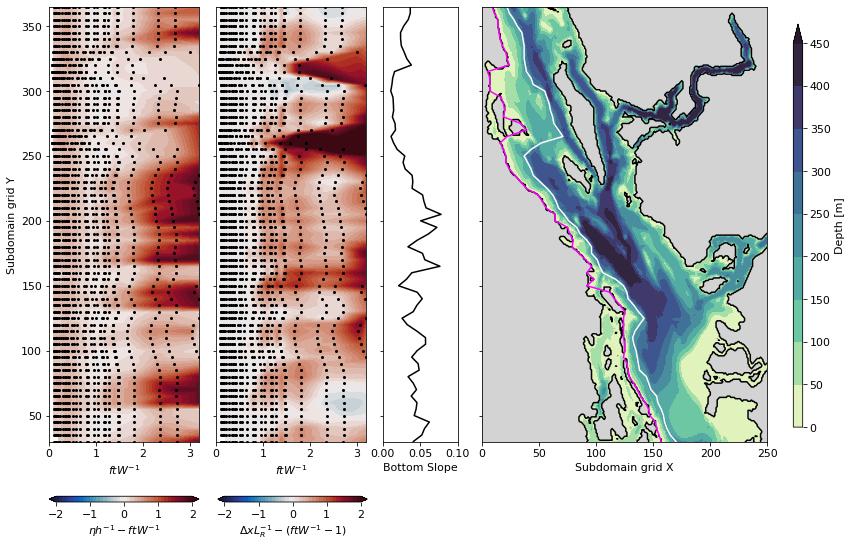

In [28]:
fig, axs, x, zh, x_u, z_u, s = plot_results()
fig.savefig('/home/bmoorema/Desktop/idealized_results.pdf', bbox_inches='tight')

### Topographic dependence (Burger number)

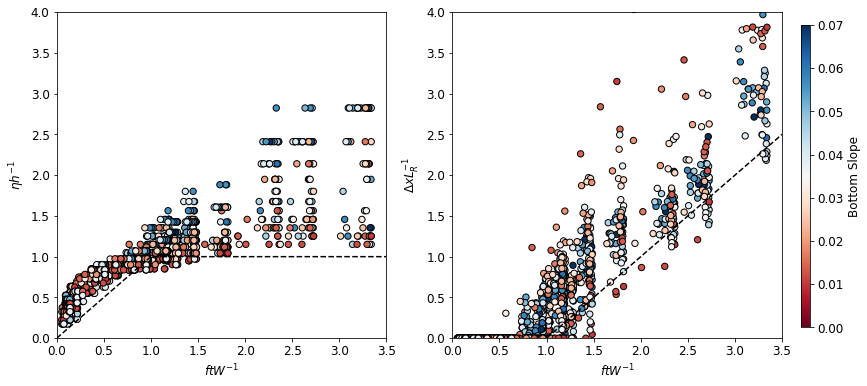

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
for ax in axs:
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ftW^{-1}$')

axs[0].plot([0, 1, 3.5], [0, 1, 1], 'k--')
c = axs[0].scatter(x, z_u, s=40, c=s, vmin=0, vmax=0.07, edgecolor='k', cmap='RdBu')
axs[0].set_ylabel('$\\eta h^{-1}$')

axs[1].plot([1, 3.5], [0, 2.5], 'k--')
axs[1].scatter(x, x_u, s=40, c=s, vmin=0, vmax=0.07, edgecolor='k', cmap='RdBu')
axs[1].set_ylabel('$\Delta xL_R^{-1}$')

fig.colorbar(c, cax=cax, label='Bottom Slope')

fig.savefig('/home/bmoorema/Desktop/idealized_bottomslope.pdf', bbox_inches='tight')